In [1]:
import os
if os.getcwd().endswith('notebooks'):
    os.chdir('..')

In [2]:
from mturk.mturktools import adhoc_fix

In [3]:
from pyhocon import ConfigFactory
from tqdm import tqdm

In [4]:
import sys
from io import StringIO
%matplotlib inline
import seaborn as sns

In [5]:
# for evaluating individual rows
from cort.core import corpora
from mturk.evaluate_full_annotation import extract_conll, run_evaluation_script
from mturk.extract_results import extract_results_from_log_file
import subprocess
from io import StringIO
from config import scorer
import tempfile
import re

# Reading annotations

In [58]:
import pandas as pd
anns = pd.concat([
    pd.read_csv(adhoc_fix('output/mturk/cltl-2019-01-23-unmasked-annotations.csv')),
    pd.read_csv(adhoc_fix('output/mturk/cltl-2019-01-23-masked-annotations.csv'))
])

In [59]:
anns.head(3)

,blanks,chains,conll_file,doc,events,improvement,problems,sent_begin,sent_end,submit,workerId
0,NaN,"mention_22_24,mention_25_25=mention_6_6=mentio...",output/conll-2012-transformed.v2/orig/dev/bn_c...,(bn/cnn/02/cnn_0200); part 000,1447:start_grouping;1447:add_singleton(mention...,NaN,NaN,0,3,NaN,A19NP6Q2D7YHSV
1,NaN,"mention_3_5=mention_28_34,mention_7_7,mention_...",output/conll-2012-transformed.v2/orig/dev/bn_v...,(bn/voa/00/voa_0090); part 000,182776:start_grouping;182776:add_singleton(men...,NaN,NaN,0,3,NaN,A3V5LQ8PYCTKQB
2,NaN,mention_0_0=mention_6_6=mention_11_11=mention_...,output/conll-2012-transformed.v2/orig/dev/pt_n...,(pt/nt/40/nt_4020); part 001,141:display_instructions;33290:close_instructi...,NaN,NaN,0,37,NaN,A1WF8OS5DR3JRB


In [61]:
def extract_transformation(conll_path):
    transformation, = re.findall(r'output/conll-2012[-\w\.]+/([-\d\w]+)/dev', conll_path)
    return transformation

anns['transformation'] = anns.conll_file.apply(extract_transformation)

In [62]:
anns.head(3)

,blanks,chains,conll_file,doc,events,improvement,problems,sent_begin,sent_end,submit,workerId,transformation
0,NaN,"mention_22_24,mention_25_25=mention_6_6=mentio...",output/conll-2012-transformed.v2/orig/dev/bn_c...,(bn/cnn/02/cnn_0200); part 000,1447:start_grouping;1447:add_singleton(mention...,NaN,NaN,0,3,NaN,A19NP6Q2D7YHSV,orig
1,NaN,"mention_3_5=mention_28_34,mention_7_7,mention_...",output/conll-2012-transformed.v2/orig/dev/bn_v...,(bn/voa/00/voa_0090); part 000,182776:start_grouping;182776:add_singleton(men...,NaN,NaN,0,3,NaN,A3V5LQ8PYCTKQB,orig
2,NaN,mention_0_0=mention_6_6=mention_11_11=mention_...,output/conll-2012-transformed.v2/orig/dev/pt_n...,(pt/nt/40/nt_4020); part 001,141:display_instructions;33290:close_instructi...,NaN,NaN,0,37,NaN,A1WF8OS5DR3JRB,orig


# Overal results

In [186]:
results = pd.read_csv('output/mturk/cltl-2019-01-23.csv')

In [187]:
results

,auto_or_gold,dataset,f1_bcub,f1_ceafe,f1_conll,f1_muc,manipulation,mention_p,mention_r,system
0,NaN,dev,81.22,74.32,76.086667,72.72,men_10,100,100,human
1,NaN,dev,86.12,74.07,79.036667,76.92,men_20,100,100,human
2,NaN,dev,82.43,61.97,78.470000,91.01,men_30,100,100,human
3,NaN,dev,73.37,57.82,69.783333,78.16,men_40,100,100,human
4,NaN,dev,59.02,53.33,54.116667,50.00,men_60,100,100,human
5,NaN,dev,53.96,29.37,38.146667,31.11,men_70,100,100,human
6,NaN,dev,92.63,90.82,92.726667,94.73,no-external,100,100,human
7,NaN,dev,89.14,78.39,86.073333,90.69,no-internal,100,100,human
8,NaN,dev,86.81,72.96,83.126667,89.61,no-name,100,100,human
9,NaN,dev,93.55,90.29,92.390000,93.33,nonmen_10,100,100,human


# Compare workers

In [72]:
from glob import glob
workers_data = []
for path in glob('output/mturk/cltl-2019-01-23-evaluate/workers/*.log'):
    workers_data.append({
        'workerId': os.path.basename(path).replace('.log', ''),
        **extract_results_from_log_file(path)
    })

File: output/mturk/cltl-2019-01-23-evaluate/workers/A2ZSJQ8UYSJ8LX.log
File: output/mturk/cltl-2019-01-23-evaluate/workers/A37IPL6DILIK8T.log
File: output/mturk/cltl-2019-01-23-evaluate/workers/A3V5LQ8PYCTKQB.log
File: output/mturk/cltl-2019-01-23-evaluate/workers/A19NP6Q2D7YHSV.log
File: output/mturk/cltl-2019-01-23-evaluate/workers/A1WF8OS5DR3JRB.log
File: output/mturk/cltl-2019-01-23-evaluate/workers/A1I8TJRTQ5NI2I.log


In [73]:
workers = pd.DataFrame(workers_data)

In [143]:
event_durations_data = []
for _, row in anns.iterrows():
    event_start_timestamps = [0] + [int(evt.split(':')[0]) for evt in row['events'].split(';')]
    event_durations = [end-start for start, end in zip(event_start_timestamps[:-1], event_start_timestamps[1:])]
    event_durations_data.extend({'workerId': row['workerId'], 
                                 'conll_file': row['conll_file'],
                                 'event_duration_sec': d / 1000} 
                                for d in event_durations if d > 0)

In [144]:
event_durations = pd.DataFrame(event_durations_data)

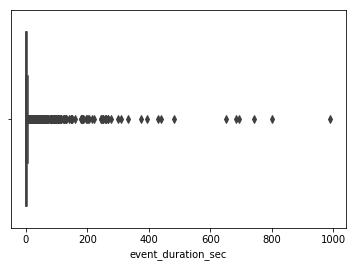

In [146]:
_ = sns.boxplot(event_durations.event_duration_sec)

We cut off some extreme cases because during the session, sometimes we stopped for discussion or pizza. 

In [184]:
threshold = event_durations.event_duration_sec.quantile(0.99)
print('Threshold = %.1f sec' %threshold)

Threshold = 93.6 sec


In [155]:
event_durations_filtered = event_durations[event_durations.event_duration_sec <= threshold]

In [159]:
doc_completion_time = event_durations_filtered.groupby(['workerId', 'conll_file']).sum()
doc_completion_time['doc_completion_min'] = doc_completion_time['event_duration_sec'] / 60
doc_completion_time = doc_completion_time.drop(columns='event_duration_sec')

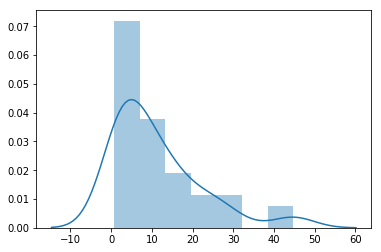

In [162]:
_ = sns.distplot(doc_completion_time)

In [160]:
doc_completion_time.describe()

,doc_completion_min
count,42.000000
mean,11.176073
std,10.929216
min,0.744317
25%,3.243383
50%,8.170033
75%,15.522025
max,44.760850


In [176]:
time_per_worker = doc_completion_time.groupby('workerId').mean()
time_per_worker['docs_per_hour'] = 60 / time_per_worker['doc_completion_min']

In [180]:
counts = anns.groupby('workerId').size()
workload = counts * 100.0 / counts.sum()
workload.name = 'workload_pct'

In [181]:
workers_with_workload = workers.set_index('workerId').join(workload).join(time_per_worker).reset_index()

In [182]:
results_long_form = pd.melt(workers_with_workload[['workerId', 'f1_conll', 'workload_pct', 'docs_per_hour']], 
                            id_vars="workerId", var_name="measurement", value_name="value")

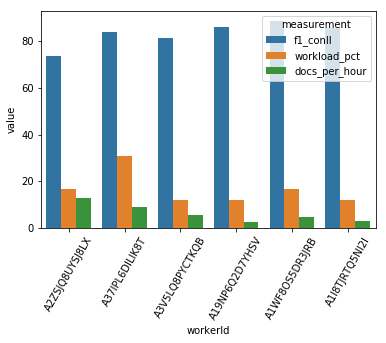

In [183]:
ax = sns.barplot(x='workerId', y='value', hue='measurement', data=results_long_form)
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=60)

# Look at abnormal points in the data

The performance of CLTL annotators is abnormally low at `nonmen_40` and high at `nonmen_60`. Similarly, `men_20` and `men_30` is done better than `men_10`. let's see if something was wrong?

In [52]:
anns.groupby('transformation').size()

transformation
men_10         2
men_20         1
men_30         1
men_40         1
men_60         1
men_70         1
no-external    2
no-internal    3
no-name        2
nonmen_10      2
nonmen_20      3
nonmen_40      1
nonmen_50      3
nonmen_60      1
nonmen_70      6
dtype: int64

In [42]:
anns[anns.transformation == 'nonmen_40']

,blanks,chains,conll_file,doc,events,improvement,problems,sent_begin,sent_end,submit,workerId,transformation
2,NaN,mention_0_0=mention_3_3=mention_16_16=mention_...,output/conll-2012-transformed.v2/nonmen_40/dev...,(bc/msnbc/00/msnbc_0000); part 019,652140:start_grouping;652140:add_singleton(men...,NaN,NaN,0,13,NaN,A2ZSJQ8UYSJ8LX,nonmen_40


In [43]:
anns[anns.transformation == 'nonmen_60']

,blanks,chains,conll_file,doc,events,improvement,problems,sent_begin,sent_end,submit,workerId,transformation
24,"blank_token_34=_when_or,blank_token_35=_someth...",mention_0_7=mention_44_44=mention_47_47=mentio...,output/conll-2012-transformed.v2/nonmen_60/dev...,(nw/wsj/24/wsj_2423); part 000,372795:start_grouping;372795:add_singleton(men...,NaN,Only worked because it was short,0,4,NaN,A37IPL6DILIK8T,nonmen_60


# Evaluate individual assignment

(don't know what to do with this yet)

In [63]:
def evaluate_assignment(ann_row):
    _, ann_doc = extract_conll(ann_row)
    path_gold = ann_row['conll_file']
    base_name = os.path.basename(path_gold) + '_' + ann_row['workerId'] + '_'
    _, path_ann = tempfile.mkstemp(suffix='.ann_conll', prefix=base_name)
    with open(path_ann, 'w') as f:
        corpora.Corpus("ann", [ann_doc]).write_to_file(f)
    eval_output = subprocess.check_output([scorer, 'all', path_gold, path_ann])
    return extract_results_from_log_file(StringIO(eval_output.decode('utf-8')))

In [64]:
evaluate_assignment(anns.iloc[0])

{'mention_r': '100',
 'mention_p': '100',
 'f1_muc': '72.72',
 'f1_bcub': '84.74',
 'f1_ceafe': '75.15',
 'f1_conll': 77.53666666666666}